In [1]:
import numpy as np
from skimage import io, util, measure, filters, morphology
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator
from scipy import spatial

from measurements import get_mesh_from_bm_image,get_tissue_curvatures
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

 
def find_z_of_maximal_gradient(im_diff,z_shift,threshold=0.2,method='threshold'):
    ZZ,YY,XX = im_diff.shape

    if method == 'maximum':
        idx = np.argmax(im_diff,axis=0)

    if method == 'threshold':
        idx = np.zeros((YY,XX))
        for x in range(XX):
            for y in range(YY):
                hits = np.where(im_diff[:,y,x] > threshold)[0]
                if len(hits)>0:
                    idx[y,x] = hits[0]
    heightmap = idx
    
    Iz = np.round(heightmap + z_shift).astype(int)
    Iz[Iz >= ZZ] = ZZ-1
    return Iz
    
def get_z_gradient(imblur,sign):
    _tmp = imblur.copy().astype(float)
    _tmp[np.isnan(_tmp)] = 0
    _tmp_diff = sign * np.diff(_tmp,axis=0)
    
    return _tmp_diff

In [2]:
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2'

height_image = io.imread(path.join(dirname,'0. Day 0/height_image.tif'))
heightmap = io.imread(path.join(dirname,'0. Day 0/heightmap.tif'))

R = io.imread(path.join(dirname,'0. Day 0/R_reg.tif'))

stackview.orthogonal(R, zoom_factor=0.5,continuous_update=True)


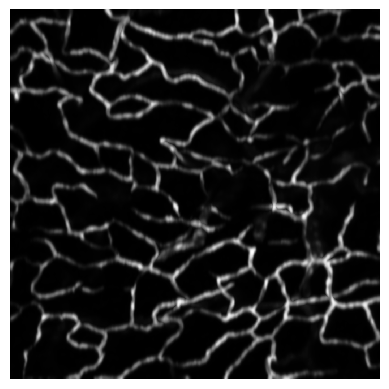

In [3]:
R_filt = gaussian_filter(R,[5,5,2])
R_filt_MIP = R_filt.max(axis=0)
stackview.imshow(R_filt_MIP)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 800x500 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

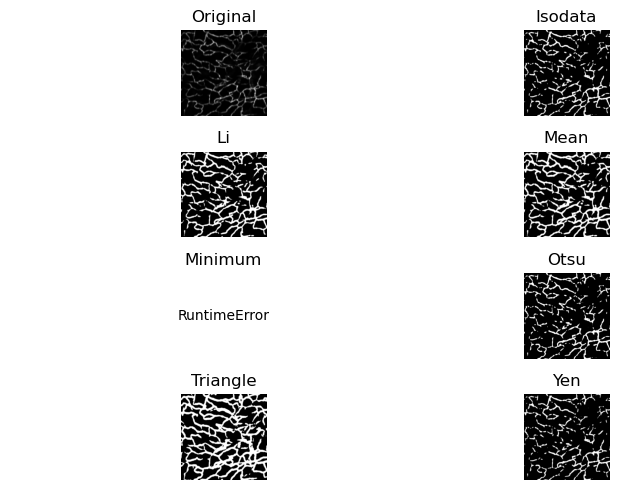

In [4]:
filters.try_all_threshold(R_filt_MIP)

In [5]:
vessel_mask = R_filt_MIP > filters.threshold_mean(R_filt_MIP)

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


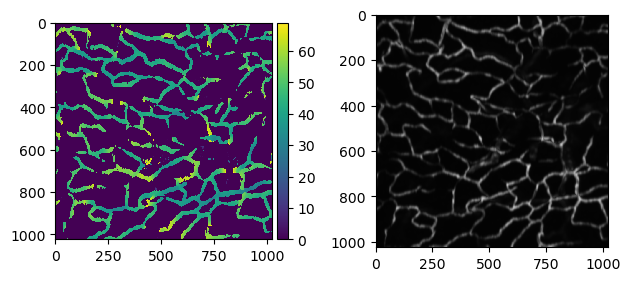

In [6]:
R_filt_diff = get_z_gradient(R_filt,sign=-1)
Iz = find_z_of_maximal_gradient(R_filt_diff,z_shift=0)
Iz[~vessel_mask] = 0
plt.subplot(1,2,1)
io.imshow(Iz)
plt.subplot(1,2,2)
io.imshow(R_filt_MIP)

# Skeletonize

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


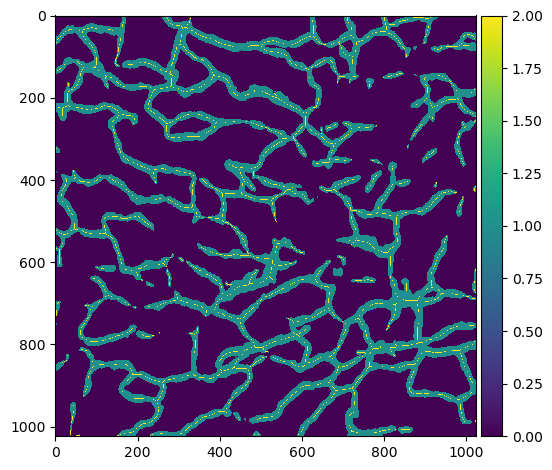

In [107]:
skeleton = morphology.skeletonize(vessel_mask)
io.imshow( vessel_mask.astype(int) + skeleton.astype(int))

In [98]:
Iz_skeleton.shape

(1024, 1024)

In [103]:
# Draw skeleton in 3D

Iz_skeleton = Iz.copy()
Iz_skeleton[~skeleton] = 0

# Clean up vessels above basement membrane
Iz_skeleton[(Iz_skeleton - heightmap) < 0] = 0

# Draw on 3D image
Y,X = np.where(Iz_skeleton)
vessel_image = np.zeros_like(R_filt)
for y,x in zip(Y,X):
    vessel_image[Iz[y,x],y,x] = 1


In [105]:
selem = morphology.ball(2)
vessel_image_thicker = morphology.dilation(vessel_image)
stackview.orthogonal(vessel_image_thicker,zoom_factor=0.5)

In [106]:
io.imsave(path.join(dirname,'0. Day 0/vessel_image_thicker.tif'),vessel_image_thicker)
io.imsave(path.join(dirname,'0. Day 0/vessel_image.tif'),vessel_image)

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/0. Day 0/vessel_image_thicker.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/0. Day 0/vessel_image.tif is a low contrast image
  return func(*args, **kwargs)


# Relate to curvature

In [114]:
curvature = np.load(path.join(dirname,'0. Day 0/curvature.npz'))['arr_0']
# np.savez(path.join(dirname,'0. Day 0/curvature.npz'),t0_reconstructed)
curvature_skeleton = curvature[Iz_skeleton > 0]


np.float64(-0.007446087680572909)

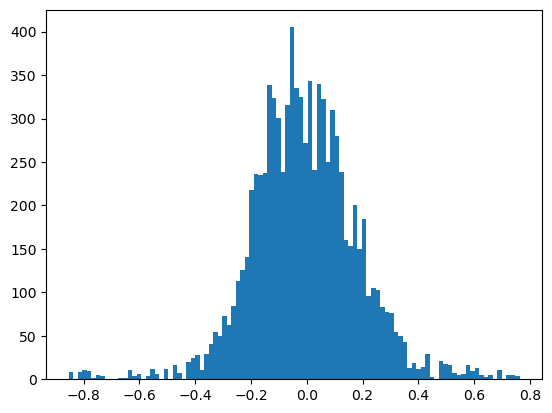

In [115]:
plt.hist(curvature_skeleton[curvature_skeleton != 0],100)
curvature_skeleton[curvature_skeleton != 0].mean()


array([-11, -16, -16, ..., -19, -25, -25])

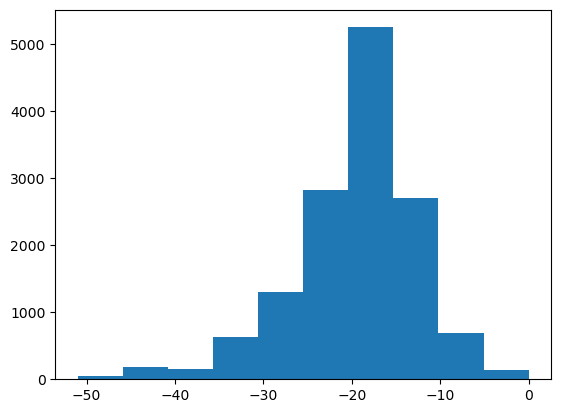

In [117]:
dist_to_bm = (heightmap_masked - Iz_skeleton)
dist_to_bm_skeleton = dist_to_bm[Iz_skeleton > 0]
plt.hist(dist_to_bm_skeleton)
dist_to_bm_skeleton

Text(0.5, 1.0, 'corr = 0.13293053806675795')

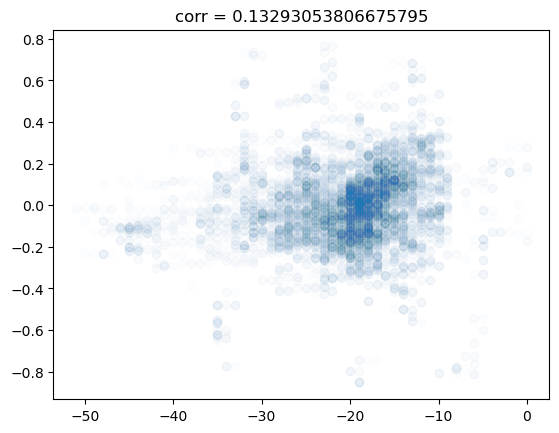

In [121]:
plt.scatter(dist_to_bm_skeleton[curvature_skeleton != 0],
            curvature_skeleton[curvature_skeleton != 0],alpha=0.01)
plt.title( f'corr = {np.corrcoef(dist_to_bm_skeleton[curvature_skeleton != 0],
            curvature_skeleton[curvature_skeleton != 0])[0,1]}')